In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

import sleep_study as ss
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 30})
plt.rc('text', usetex=True)

In [3]:
ss.init()

age information stored in /home/harlinl/sleep_study_harlin/age_file.csv


In [4]:
# stats for number of sleep studies

df = ss.info.load_health_info('SLEEP_STUDY.csv')
print("There are {} sleep studies in this dataset".format(len(df)))
vcs = df['STUDY_PAT_ID'].value_counts()
vcs = vcs.sort_values()
print("Representing {} unique patients".format(len(vcs)))
one_vcs = vcs[vcs == 1]
print("There are {} patients with 1 sleep study".format(len(one_vcs)))
two_vcs = vcs[vcs == 2]
print("There are {} patients with 2 sleep studies".format(len(two_vcs)))
more_vcs = vcs[vcs > 2]
print("There are {} patients with more than two sleep studies, "
          "with {} being the largest number of sleep studies for any one patient".format(len(more_vcs), max(vcs)))

There are 3984 sleep studies in this dataset
Representing 3673 unique patients
There are 3400 patients with 1 sleep study
There are 238 patients with 2 sleep studies
There are 35 patients with more than two sleep studies, with 5 being the largest number of sleep studies for any one patient


In [5]:
# stats for gender

df = ss.info.load_health_info('DEMOGRAPHIC.csv')
df.drop_duplicates(subset=['STUDY_PAT_ID', 'GENDER_DESCR'], inplace=True)
vcs = df['GENDER_DESCR'].value_counts()
print("Here is the gender breakdown: ")
print(vcs)

Here is the gender breakdown: 
Male       2068
Female     1604
Unknown       1
Name: GENDER_DESCR, dtype: int64


In [6]:
# stats for race

df = ss.info.load_health_info('DEMOGRAPHIC.csv')
df.drop_duplicates(subset=['STUDY_PAT_ID', 'RACE_DESCR'], inplace=True)
vcs = df['RACE_DESCR'].value_counts()
print("Here is the race breakdown: ")
print(vcs)

Here is the race breakdown: 
White                                        2433
Black or African American                     738
Multiple race                                 277
Unknown                                       115
Asian                                          93
Refuse to answer                                9
Native Hawaiian or Other Pacific Islander       5
American Indian or Alaska Native                3
Name: RACE_DESCR, dtype: int64


In [7]:
# stats for ethnicity

df = ss.info.load_health_info('DEMOGRAPHIC.csv')
df.drop_duplicates(subset=['STUDY_PAT_ID', 'ETHNICITY_DESCR'], inplace=True)
vcs = df['ETHNICITY_DESCR'].value_counts()
print("Here is the ethnicity breakdown: ")
print(vcs)

Here is the ethnicity breakdown: 
Not Hispanic or Latino    3446
Hispanic or Latino         186
Other                       23
Unknown                     15
No information               3
Name: ETHNICITY_DESCR, dtype: int64


There are 2414 patients who are less than 10
There are 20 patients who are more than 30
The youngest patient at the time of the sleep study was 6 days old
The oldest patient at the time of the sleep study was 58.391780821917806


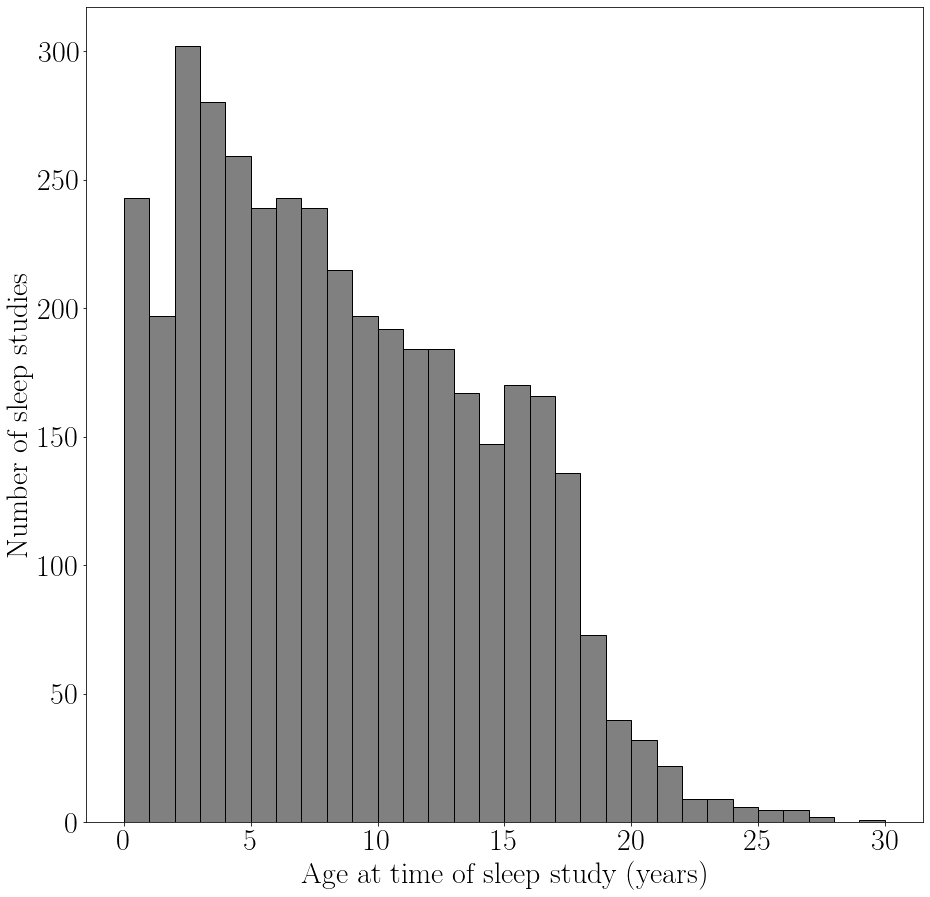

In [8]:
# stats for age at sleep study

df = ss.info.load_health_info('SLEEP_STUDY.csv')

age_at_study = list(df['AGE_AT_SLEEP_STUDY_DAYS'])
print("There are {} patients who are less than {}".format(len(df[df['AGE_AT_SLEEP_STUDY_DAYS'] < (10*365)]), 10))
print("There are {} patients who are more than {}".format(len(df[df['AGE_AT_SLEEP_STUDY_DAYS'] > (30*365)]), 30))
print("The youngest patient at the time of the sleep study was {} days old".format(min(age_at_study)))
ages = [age/365 for age in age_at_study]
print("The oldest patient at the time of the sleep study was {}".format(max(ages)))
plt.figure(figsize=(15,15))

plt.hist(ages, bins=range(31), color='grey', edgecolor='black')
plt.xlabel('Age at time of sleep study (years)')
plt.ylabel('Number of sleep studies')
plt.savefig('age_dist.pdf', bbox_inches = 'tight', pad_inches = 0)
plt.show()

# Length of care at NCH before and after first sleep study

In [9]:
def get_first_study():
    
    fs_time = {'STUDY_PAT_ID': [], 'FIRST_SLEEP_STUDY_DATETIME': []}
    sleep_df = ss.info.load_health_info('SLEEP_STUDY.csv')
    
    for i, pat_id in enumerate(list(set(sleep_df['STUDY_PAT_ID']))):
        pat_ss = sleep_df[sleep_df['STUDY_PAT_ID']==pat_id]
        pat_ss = pd.to_datetime(pat_ss['SLEEP_STUDY_START_DATETIME'])
        fs_time['STUDY_PAT_ID'].append(pat_id)
        fs_time['FIRST_SLEEP_STUDY_DATETIME'].append(min(pat_ss.values))
    
    fs_time = pd.DataFrame.from_dict(fs_time)
    print('number of patients', len(fs_time))
    return fs_time

def get_date_range(study_pat_id, diag_df, enc_df, med_df, meas_df, proc_df, proc_surg_df):
    all_dates = []
    for df in [diag_df, enc_df, med_df, meas_df, proc_df, proc_surg_df]:
        all_dates += get_df_dates(study_pat_id, df, all_dates)
    all_dates = validate_dates(all_dates)
    if len(all_dates) == 0:
        print(study_pat_id)
        return 0, 0
    else:
        return min(all_dates), max(all_dates)


def validate_dates(all_dates):
    ndates = []
    for date in all_dates:
        if (date.year >= 1950) and (date.year <= 2022):
            ndates.append(date)
    return ndates


def get_df_dates(study_pat_id, df, all_dates):
    ndf = df[df['STUDY_PAT_ID'] == study_pat_id]
    columns = list(ndf)
    for col in columns:
        if col != 'STUDY_PAT_ID':
            all_dates += list(ndf[col])
    return all_dates

In [10]:
fs_time = get_first_study()
pat_ids = list(fs_time['STUDY_PAT_ID'])
print('number of patients', len(pat_ids))

diag_df = ss.info.load_health_info('DIAGNOSIS.csv')
diag_df = diag_df[['STUDY_PAT_ID', 'DX_START_DATETIME', 'DX_END_DATETIME']]

enc_df = ss.info.load_health_info('ENCOUNTER.csv')
enc_df = enc_df[['STUDY_PAT_ID', 'ENCOUNTER_DATE', 'VISIT_START_DATETIME', 'VISIT_END_DATETIME',
                 'ADT_ARRIVAL_DATETIME', 'ED_DEPARTURE_DATETIME']]

med_df = ss.info.load_health_info('MEDICATION.csv')
med_df = med_df[['STUDY_PAT_ID', 'MED_START_DATETIME', 'MED_END_DATETIME', 'MED_ORDER_DATETIME',
                 'MED_TAKEN_DATETIME']]

meas_df = ss.info.load_health_info('MEASUREMENT.csv')
meas_df = meas_df[['STUDY_PAT_ID', 'MEAS_RECORDED_DATETIME']]

proc_df = ss.info.load_health_info('PROCEDURE.csv')
proc_df = proc_df[['STUDY_PAT_ID', 'PROCEDURE_DATETIME']]

proc_surg_df = ss.info.load_health_info('PROCEDURE_SURG_HX.csv')
proc_surg_df = proc_surg_df[['STUDY_PAT_ID', 'PROC_NOTED_DATE', 'PROC_START_TIME', 'PROC_END_TIME']]

patient_care = {'STUDY_PAT_ID': [], 'EARLIEST_CARE': [], 'MOST_RECENT_CARE': [], 'FIRST_SLEEP_STUDY_DATETIME': []}
for study_pat_id in pat_ids:
    min_date, max_date = get_date_range(study_pat_id, diag_df, enc_df, med_df, meas_df, proc_df, proc_surg_df)

    patient_care['STUDY_PAT_ID'].append(study_pat_id)

    ss_date = fs_time[fs_time['STUDY_PAT_ID']==study_pat_id]
    ss_date = ss_date['FIRST_SLEEP_STUDY_DATETIME'].values[0]
    patient_care['FIRST_SLEEP_STUDY_DATETIME'].append(ss_date)

    if min_date:
        patient_care['EARLIEST_CARE'].append(min_date)
        patient_care['MOST_RECENT_CARE'].append(max_date)
    else:
        patient_care['EARLIEST_CARE'].append(ss_date)
        patient_care['MOST_RECENT_CARE'].append(ss_date)            

out_fp = 'patient_care_range.csv'
pc_df = pd.DataFrame(patient_care, columns=['STUDY_PAT_ID', 'EARLIEST_CARE', 'MOST_RECENT_CARE', 'FIRST_SLEEP_STUDY_DATETIME'])
pc_df.to_csv(out_fp, index=False)

number of patients 3673
number of patients 3673


/home/harlinl/anaconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/harlinl/anaconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (12,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


5866


Here are the patients with pre-sleep-study length of care < 30 days
      STUDY_PAT_ID EARLIEST_CARE    MOST_RECENT_CARE  \
50              91    2017-08-10 2019-09-03 00:00:00   
68             127    2018-02-28 2018-09-11 00:00:00   
102           8389    2019-07-01 2019-10-27 00:00:00   
126            238    2018-12-14 2020-03-11 23:59:00   
194           8581    2019-05-24 2019-10-12 00:00:00   
...            ...           ...                 ...   
3579          7909    2018-03-22 2018-04-25 00:00:00   
3581         16105    2019-10-19 2020-03-02 00:00:00   
3594          7945    2018-09-28 2019-05-11 19:05:00   
3615          8011    2019-06-16 2019-08-20 23:59:00   
3624         16225    2019-06-24 2021-03-19 00:37:00   

     FIRST_SLEEP_STUDY_DATETIME  LENGTH_CARE_BEFORE_DAYS  
50          2017-09-05 19:55:45                       26  
68          2018-03-22 18:41:13                       22  
102         2019-07-12 08:48:14                       11  
126         2018-12-19 

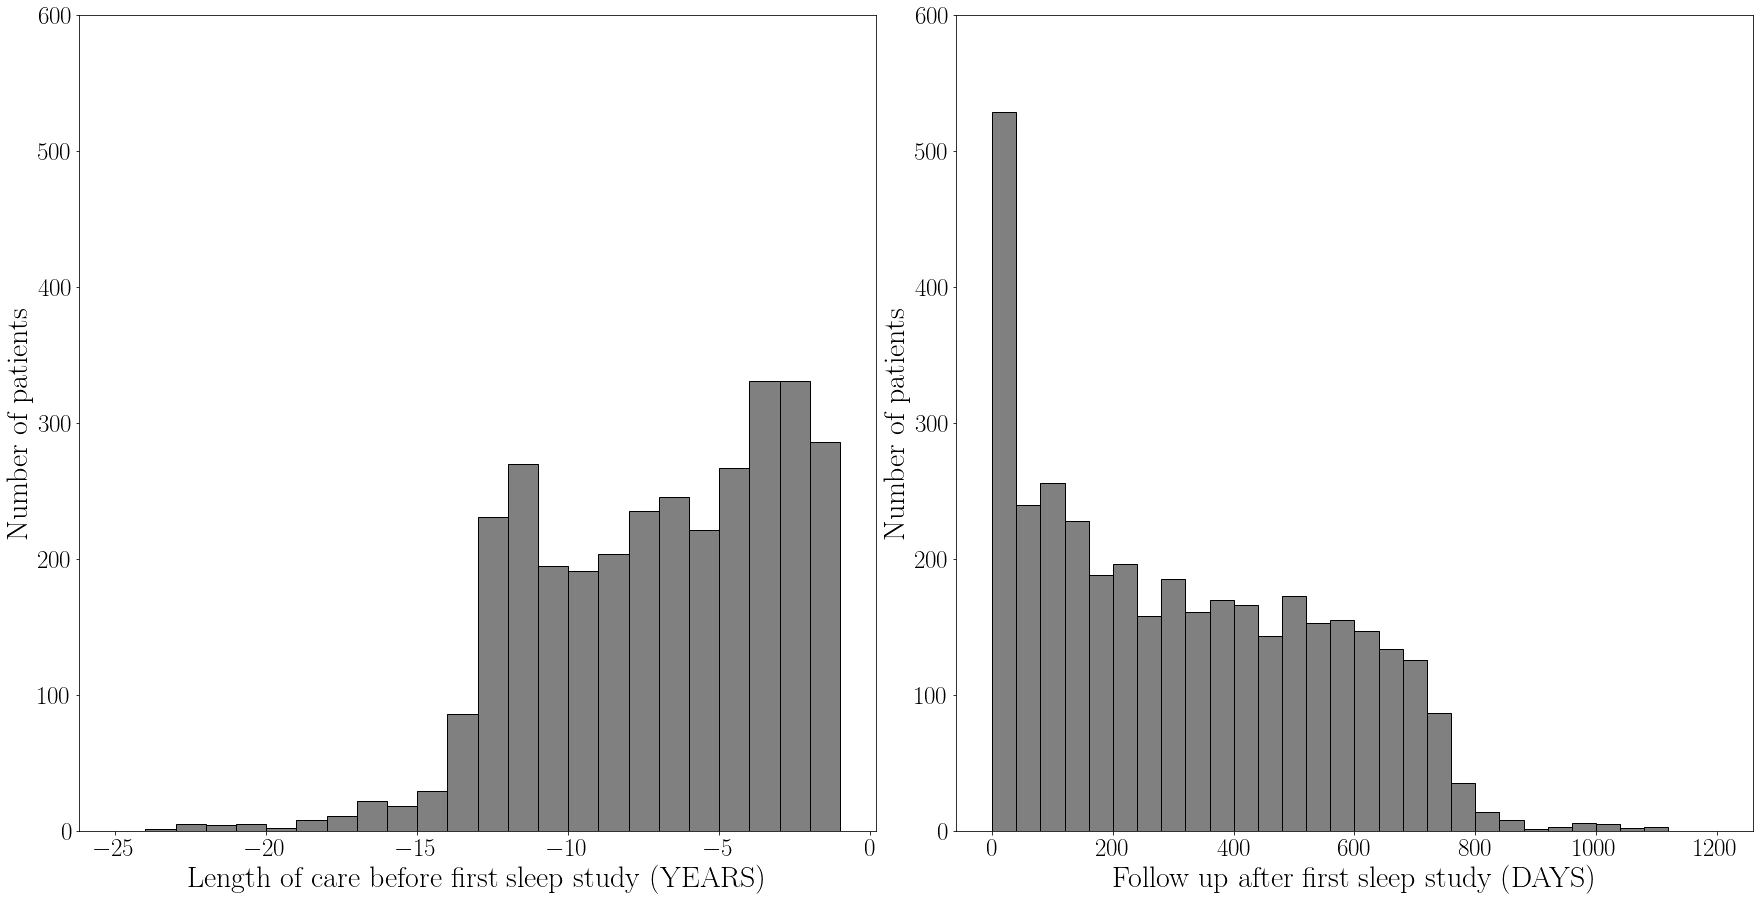

In [11]:
# Note that length of care == 0 can result from bad date fields, or no encounters entered

in_fp = os.path.join('patient_care_range.csv')
df = pd.read_csv(in_fp)
df['EARLIEST_CARE'] = pd.to_datetime(df['EARLIEST_CARE'])
df['MOST_RECENT_CARE'] = pd.to_datetime(df['MOST_RECENT_CARE'])
df['FIRST_SLEEP_STUDY_DATETIME'] = pd.to_datetime(df['FIRST_SLEEP_STUDY_DATETIME'])

fig, axs = plt.subplots(1, 2, figsize=(30,15))

time_before = df['FIRST_SLEEP_STUDY_DATETIME'] - df['EARLIEST_CARE']
time_after = df['MOST_RECENT_CARE'] - df['FIRST_SLEEP_STUDY_DATETIME']

df['LENGTH_CARE_BEFORE_DAYS'] = [day_len.days for day_len in list(time_before)]
ndf = df[df['LENGTH_CARE_BEFORE_DAYS'] < 30]
print("Here are the patients with pre-sleep-study length of care < 30 days")
print(ndf)
print()

years_before = [day_len.days/365 for day_len in list(time_before)]
years_before = np.array([-year for year in years_before])

axs[0].hist(years_before, bins=range(-25,0), color='grey', edgecolor='black')
axs[0].set_xlabel('Length of care before first sleep study (YEARS)', fontsize = 30)
axs[0].set_ylabel('Number of patients', fontsize = 30)
axs[0].set_ylim(0, 600)
axs[0].tick_params(axis='both', which='major', labelsize=25)
print('not plotting', sum(years_before<-25), 'people with less than -25 years' )

days_after = np.array([max(day_len.days, 0) for day_len in list(time_after)])

axs[1].hist(days_after, bins=range(0, 1240, 40), color='grey', edgecolor='black')
axs[1].set_xlabel('Follow up after first sleep study (DAYS)', fontsize = 30)
axs[1].set_ylabel('Number of patients', fontsize = 30)
axs[1].set_ylim(0, 600)
axs[1].tick_params(axis='both', which='major', labelsize=25)
print('not plotting', sum(days_after>1200), 'people with more than 1200 days')

plt.subplots_adjust(wspace=0.1, hspace=0)
plt.savefig('length_of_care_before_after.pdf', bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [12]:
print(len(df), len(days_after), len(years_before))
print('max and min follow up days since first sleep study', max(days_after), min(days_after))
print('mean', np.mean(days_after))
print('median', np.median(days_after))
print('more than 1 year', sum(days_after>1*365))
print('more than 2 years', sum(days_after>2*365))
print('more than 3 years', sum(days_after>3*365))
print('min', min(years_before), 'years')
print('less than -30 years', sum(years_before<-30))
print('less than -20 years', sum(years_before<-20))
print('between 90 days and 2 years', sum((days_after<2*365) & (days_after>90) ), 
      sum((days_after<2*365) & (days_after>90) )/len(days_after)*100,'%')
print('between 30 days and 2 years', sum((days_after<2*365) & (days_after>30) ), 
      sum((days_after<2*365) & (days_after>30) )/len(days_after)*100,'%') 
print('between 180 days and 2 years', sum((days_after<2*365) & (days_after>180) ), 
      sum((days_after<2*365) & (days_after>180) )/len(days_after)*100,'%')

3673 3673 3673
max and min follow up days since first sleep study 1237 0
mean 316.60931118976316
median 289.0
more than 1 year 1508
more than 2 years 137
more than 3 years 2
min -49.45205479452055 years
less than -30 years 1
less than -20 years 21
between 90 days and 2 years 2718 73.99945548597876 %
between 30 days and 2 years 3074 83.6918050639804 %
between 180 days and 2 years 2191 59.65151102640893 %
